In [1]:
%load_ext autoreload
%autoreload 2

# Simulacion de distribuciones por radio censal

**A continuación se detalla:**

1. Estimación del total de viviendas/hogares por categorías a partir del total registrado en el Precenso 2020.

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
from CENSAr.datasources import (
    tipoviv_radios_prov,
    radios_prov,
    radios_precenso_2020,
    radios_eph_censo_2010,
)

In [4]:
from CENSAr.modeling_tools import (
    tracts_2020_to_2010,
    tracts_2010_to_2001,
    simulate_cat_var,
)

In [5]:
# GEOMETRIAS
envolvente = radios_eph_censo_2010(aglo_idx="12")
corrientes_2001 = radios_prov(year=2001, prov="corrientes", mask=envolvente)
corrientes_2010 = radios_prov(year=2010, prov="corrientes", mask=envolvente)
corrientes_2020 = radios_precenso_2020(
    geo_filter={"prov": "18", "depto": "021"}, mask=None
)

[05:11:54] INFO     https://storage.googleapis.com/python_mdg/censar_carto/radios_eph_json.zip   ]8;id=676850;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=407772;file:///workspace/CENSAr/datasources.py#103\103]8;;\

In [6]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
tipo_2001 = tipoviv_radios_prov(
    year=2001, prov="corrientes", var_types={"LINK": "object"}
)
tipo_2001_geo = corrientes_2001.set_index("link").join(tipo_2001.set_index("link"))
tipo_2010 = tipoviv_radios_prov(
    year=2010, prov="corrientes", var_types={"link": "object"}
)
tipo_2010_geo = corrientes_2010.set_index("link").join(tipo_2010.set_index("link"))

[05:12:41] INFO     loading                                                                      ]8;id=391202;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=149304;file:///workspace/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    corrientes_2001.csv`                                                                           

[05:12:42] INFO     loading                                                                      ]8;id=82220;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=737177;file:///workspace/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    corrientes_2010.csv`                                                                           

In [7]:
corrientes_2020_ = tracts_2020_to_2010(
    tracts_2020_gdf=corrientes_2020, tracts_2010_gdf=corrientes_2010
)

# Verifico que todos los radios 2020 cuenten con referencia 2010
corrientes_2020_["link_2010"].isna().unique()

# Radios 2020 con referencias 2010 y 2001
tracts_corrientes_2020 = tracts_2010_to_2001(tracts_2020_gdf=corrientes_2020_)

/workspace/CENSAr/modeling_tools.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts_2020_gdf_rep["geometry"] = tracts_2020_gdf_rep.geometry.centroid
/workspace/CENSAr/modeling_tools.py:423: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  NaN2020["geometry"] = NaN2020.geometry.centroid
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


           INFO     loadding                                                                     ]8;id=10755;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=898163;file:///workspace/CENSAr/datasources.py#160\160]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/corrientes_conversion                   
                    _010.csv`                                                                                      

In [8]:
# Distribucion de categorias por radio censal
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="2010",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname="casilla",
    tot_colname="total_viviendas",
)

tracts_corrientes_2020["casilla_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

In [9]:
from CENSAr.plots import compare_chropleths

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


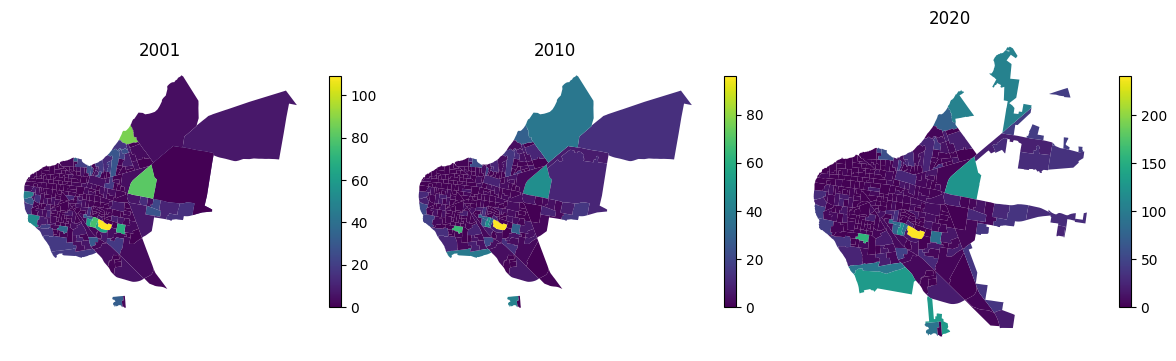

In [10]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "casilla_2020"],
    titles=[2001, 2010, 2020],
)

In [11]:
# Con catname uso la distribucion de una variable en 2001 y de otra en 2010 en funcion del diccionario que pasamos como parametro
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname={"2001": "casilla", "2010": "rancho"},
    tot_colname="total_viviendas",
)

tracts_corrientes_2020["informal_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

In [12]:
tracts_corrientes_2020["informal_2020"].sum()

3412.0

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


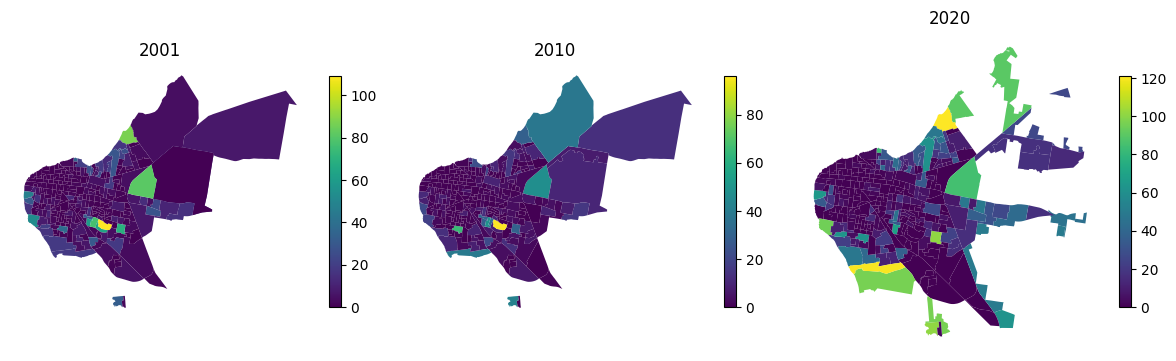

In [13]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "informal_2020"],
    titles=[2001, 2010, 2020],
)

In [14]:
from CENSAr.datasources import servurban_radios_prov

In [15]:
servurban_2001 = servurban_radios_prov(prov="corrientes", var_types={"link": "object"})
servurban_2001_geo = tipo_2001_geo.join(servurban_2001.set_index("link"))

In [16]:
simulated_distribution = simulate_cat_var(
    gdf_var_01=servurban_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname={"2001": "pavimento_no", "2010": "rancho"},
    tot_colname="total_viviendas",
)


tracts_corrientes_2020["informal_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


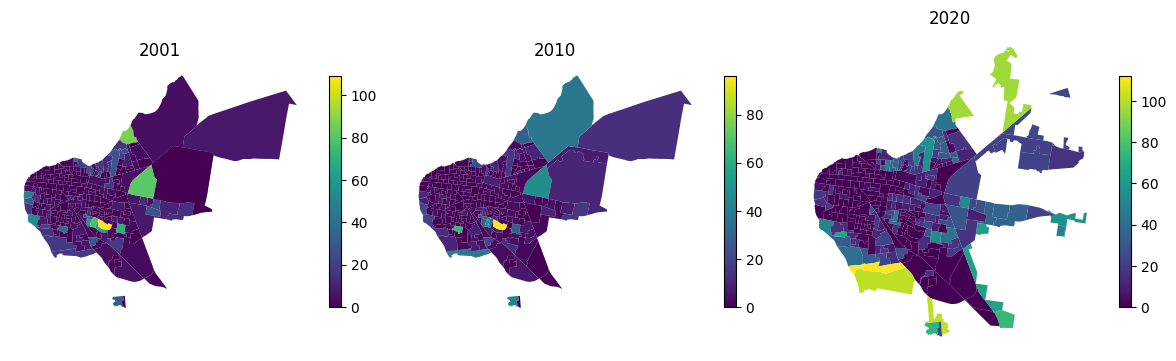

In [17]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "informal_2020"],
    titles=[2001, 2010, 2020],
)

In [19]:
from copy import deepcopy
from CENSAr.aggregation import named_aggregation

tipo_vivienda_agg_2001 = named_aggregation(
    tipo_2001_geo, name="tipo vivienda particular"
)
tipo_vivienda_agg_2010 = named_aggregation(
    tipo_2010_geo, name="tipo vivienda particular"
)

[05:13:01] INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=854776;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=564184;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=474658;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=527301;file:///workspace/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

           INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=787194;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=959760;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa a', 'pieza en hotel o pension',      ]8;id=747230;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=886081;file:///workspace/CENSAr/aggregation/core.py#123\123]8;;\
                    'casa b'}. Extra columns will be ignored.                                                      

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=599643;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=490969;file:///workspace/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

In [21]:
formal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2010,
    pct_val=2.5,
    catname={"2001": "formal", "2010": "formal"},
    tot_colname="total",
)
informal_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2010,
    pct_val=2.5,
    catname={"2001": "informal", "2010": "informal"},
    tot_colname="total",
)
calle_simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_vivienda_agg_2001,
    gdf_var_10=tipo_vivienda_agg_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tipo_vivienda_agg_2010,
    pct_val=2.5,
    catname={"2001": "situacion de calle", "2010": "situacion de calle"},
    tot_colname="total",
)

tipo_vivienda_agg_2020 = deepcopy(tipo_vivienda_agg_2010)
tipo_vivienda_agg_2010["formal"] = tipo_vivienda_agg_2010.index.map(
    formal_simulated_distribution
)
tipo_vivienda_agg_2010["informal"] = tipo_vivienda_agg_2010.index.map(
    informal_simulated_distribution
)
tipo_vivienda_agg_2010["situacion de calle"] = tipo_vivienda_agg_2010.index.map(
    calle_simulated_distribution
)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


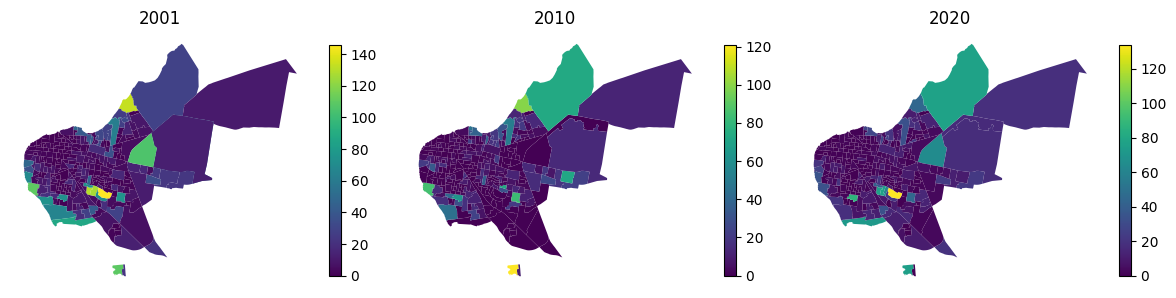

In [22]:
compare_chropleths(
    tipo_vivienda_agg_2001,
    tipo_vivienda_agg_2010,
    tipo_vivienda_agg_2020,
    column="informal",
    titles=[2001, 2010, 2020],
)

In [23]:
vulnerabilidad_2001 = named_aggregation(
    tipo_vivienda_agg_2001,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2010 = named_aggregation(
    tipo_vivienda_agg_2010,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2020 = named_aggregation(
    tipo_vivienda_agg_2020,
    name="vulnerabilidad urbana",
)

[05:13:02] INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=109897;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=910394;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=223765;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=323014;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=166340;file:///workspace/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=473859;file:///workspace/CENSAr/aggregation/core.py#67\67]8;;\

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


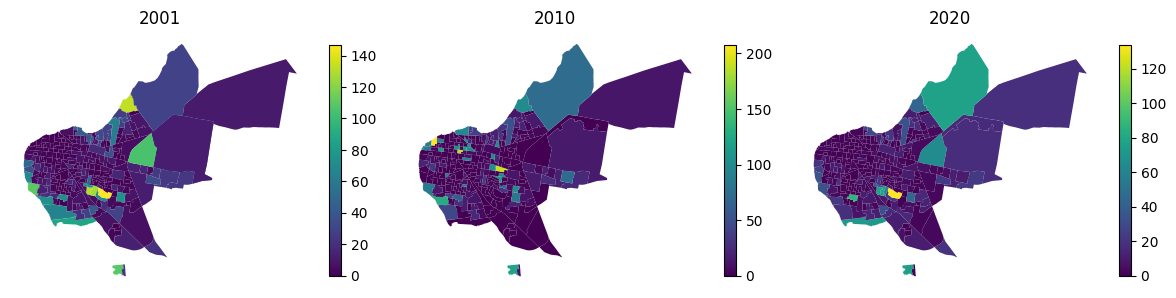

In [24]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column="vulnerable",
    titles=[2001, 2010, 2020],
)